In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

In [14]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['hour'] = df['click_time'].dt.hour
    df = df.drop(columns=['ip','click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [15]:
print('load 10% training sample + train/val')
df = pd.read_csv('train_sampling10.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
         app  device  os  channel  weekday  hour
3678108   15       1  19      245        1     8
330341     9       1  19      334        3    14
         app  device  os  channel  weekday  hour
2071426   18       1  35      121        1     6
1589237    9       1  19      234        1     0
3678108    0
330341     0
Name: is_attributed, dtype: int64
2071426    0
1589237    0
Name: is_attributed, dtype: int64


3590

In [16]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

# structure of NN: 16 - 64
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                112       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
__________

In [18]:
gc.collect()
print("start training")
# control NN's option
# batch_size = 256
# epoch = 10
batch_size = 1024
epoch = 10

# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.4, 1:0.6}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0012, 0.0008 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 3701196 samples, validate on 411244 samples
Epoch 1/10
3701196/3701196 [==============================] - 76s 20us/step - loss: 0.1067 - acc: 0.9346 - val_loss: 0.1625 - val_acc: 0.9540
Epoch 2/10
3701196/3701196 [==============================] - 75s 20us/step - loss: 0.0901 - acc: 0.9445 - val_loss: 0.1587 - val_acc: 0.9528
Epoch 3/10
3701196/3701196 [==============================] - 77s 21us/step - loss: 0.0874 - acc: 0.9468 - val_loss: 0.1635 - val_acc: 0.9510
Epoch 4/10
3701196/3701196 [==============================] - 76s 21us/step - loss: 0.0855 - acc: 0.9480 - val_loss: 0.1601 - val_acc: 0.9526
Epoch 5/10
3701196/3701196 [==============================] - 76s 21us/step - loss: 0.0843 - acc: 0.9484 - val_loss: 0.1663 - val_acc: 0.9528
Epoch 6/10
3701196/3701196 [==============================] - 76s 21us/step - loss: 0.0837 - acc: 0.9487 - val_loss: 0.1710 - val_acc: 0.9517
Epoch 7/10
3701196/3701196 [==============================] - 77s 21us/step - lo

65

[[ 0.01934143]
 [ 0.02067322]
 [ 0.0206715 ]
 ..., 
 [ 0.08220769]
 [ 0.01996324]
 [ 0.02121837]]
((411244, 1), (411244,))
         app  device  os  channel  weekday  hour
2071426   18       1  35      121        1     6
1589237    9       1  19      234        1     0
3980878    9       1  18      232        3     5
2408935   12       1  14      205        1    20
1200178    3       1  22      402        1     4


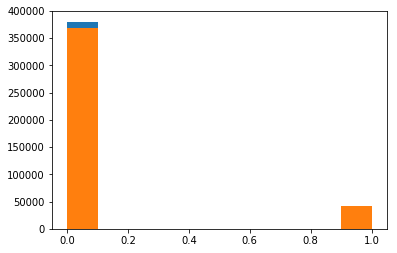

In [19]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [20]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [21]:
print("predicting")
df_sub = pd.DataFrame()
ttest = pd.read_csv('test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)



predicting
finish read test data


check result
           click_id  is_attributed
count  1.879047e+07   1.879047e+07
mean   9.395234e+06   4.337631e-02
std    5.424341e+06   1.120016e-01
min    0.000000e+00   1.722677e-02
25%    4.697617e+06   2.033917e-02
50%    9.395234e+06   2.103414e-02
75%    1.409285e+07   2.156995e-02
max    1.879047e+07   9.380325e-01


(array([  1.81389800e+07,   1.19777000e+05,   4.11320000e+04,
          7.17750000e+04,   5.05910000e+04,   1.51960000e+04,
          3.85200000e+04,   1.30800000e+04,   1.96206000e+05,
          1.05212000e+05]),
 array([ 0.01722677,  0.10930734,  0.20138792,  0.29346849,  0.38554907,
         0.47762964,  0.56971021,  0.66179079,  0.75387136,  0.84595193,
         0.93803251]),
 <a list of 10 Patch objects>)

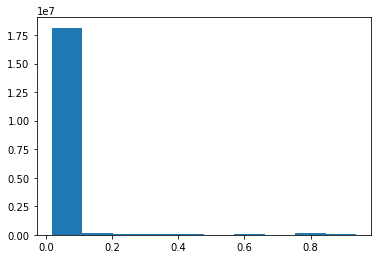

In [22]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [23]:
print("save the result")
df_sub.to_csv('sub_result/result_code3_cf4aa7b_sample10.csv',index=False)




save the result


(array([ 18428725.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,    361744.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

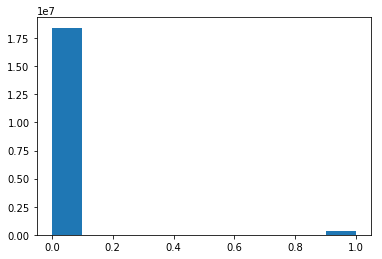

In [24]:
plt.hist(np.round(df_sub['is_attributed']))